In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import h5py
from glob import glob

archive = h5py.File("data/archive_18sco.hdf5", 'r')

In [2]:
solar_median = np.load('data/solar_median.npy')
wavelengths = np.load('data/residuals_wl.npy')

In [3]:
wl_min = 5160
wl_max = 5180

class Spectrum(object): 
    def __init__(self, wl, fl): 
        wl_range = ((wl < wl_max) & (wl > wl_min))
        self.wavelength = wl[wl_range]
        self.flux = fl[wl_range]

(0, 2)

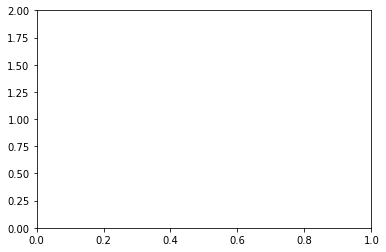

In [4]:
spectra = []
keys = list(archive)
for isot in keys: 
    sp = Spectrum(*archive[isot][:])
    spectra.append(sp)

In [19]:
# # Expensive, only run once:
dx = []
for i in range(0, len(spectra)):
    cross_corr = np.correlate(solar_median - np.median(solar_median), #spectra[0].flux - np.median(spectra[0].flux), 
                              spectra[i].flux - np.median(spectra[i].flux), mode='same')
#     plt.plot(solar_median)
#     plt.plot(np.roll(spectra[i].flux, - (cross_corr.shape[0]//2 - cross_corr.argmax())))
#     plt.show()
    dx.append(-(cross_corr.shape[0]//2 - cross_corr.argmax()))

np.save('data/dx_18Sco.npy', dx)

# dx = np.load('data/dx_18Sco.npy')

In [20]:
from astropy.time import Time
dates = Time(keys, format='isot')

In [21]:
# for i, j in zip(dates.iso, all_fs): 
#     print(i, j)

In [22]:
from json import load
f_S = load(open('../f_S.json'))

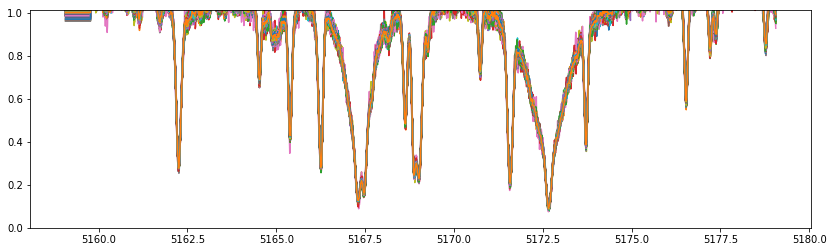

In [23]:
coadded = np.zeros_like(wavelengths) #spectra[0].flux

spectral_grid = None #spectra[0].flux #np.zeros((len(spectra)-1, len(spectra[0].wavelength)))
all_fs = []

delta_wavelength = np.median(np.abs(np.diff(spectra[0].wavelength)))

spectra_indices = []

plt.figure(figsize=(14, 4))
for i in range(0, len(spectra)): 
    # Quality filter
#     if True:
    if spectra[i].flux.max() < 1.2 and i > 2:
        spectra_indices.append(i)

        wavelength_shift = dx[i-1] * delta_wavelength
    
        rolled_spectrum = np.interp(wavelengths, spectra[i].wavelength - wavelength_shift, spectra[i].flux, left=1, right=1)
        rolled_spectrum /= np.median(rolled_spectrum)

        plt.plot(wavelengths, rolled_spectrum)
        coadded += rolled_spectrum
        if spectral_grid is None:
            spectral_grid = rolled_spectrum
        else:
            spectral_grid = np.vstack([spectral_grid, rolled_spectrum])

coadded /= np.median(coadded)
        
# plt.xlim([tio - 5, tio + 5])
plt.ylim([0, 1.01])
spectra_indices = np.array(spectra_indices)

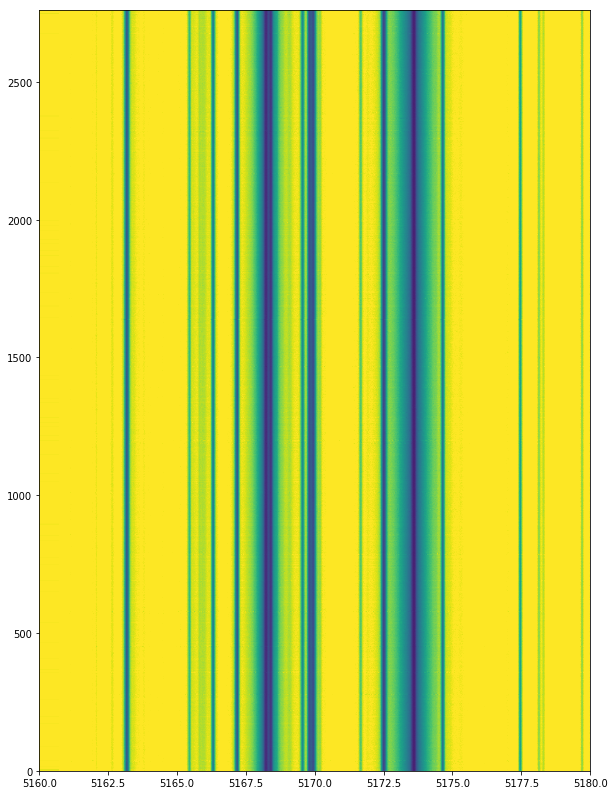

In [24]:
plt.figure(figsize=(14, 14))
extent = [spectra[0].wavelength.min(), spectra[0].wavelength.max(), 
          0, len(spectra_indices)]
plt.imshow(spectral_grid, origin='lower', extent=extent, vmin=0, vmax=1)
plt.gca().set_aspect(0.01)

In [34]:
median_18sco = np.median(spectral_grid, axis=0)
cross_corr = np.correlate(median_18sco - np.median(median_18sco), 
                          solar_median - np.median(solar_median), mode='same')
dx = cross_corr.shape[0]//2 - cross_corr.argmax()

rolled_spectral_grid = np.roll(spectral_grid, dx, axis=1)
# median_18sco = np.roll(median_18sco, dx)
# plt.plot(wavelengths, median_18sco)
# plt.plot(wavelengths, solar_median)

In [36]:
residuals = np.zeros_like(rolled_spectral_grid)

for i in range(10):#spectral_grid.shape[0]): 
    X = np.vstack([rolled_spectral_grid[i], wavelengths - wavelengths.mean(), 
                   np.ones(len(wavelengths))]).T
    c = np.linalg.lstsq(X, solar_median)[0]
    residuals[i, :] = X @ c - solar_median
    
#     plt.plot(wavelengths, X @ c)

#     plt.plot(wavelengths, solar_median)
#     plt.show()
    
    residuals[i, :] -= np.median(residuals[i, :])
    residuals[i, :] /= residuals[i, :].ptp()

/Users/bmmorris/anaconda/lib/python3.5/site-packages/ipykernel_launcher.py:6: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  


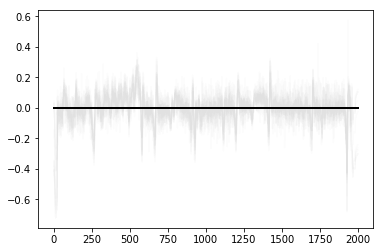

In [46]:
# for residual in residuals: 
#     plt.plot(residual, alpha=0.01, color='k')

plt.plot(residuals.T, alpha=0.01, color='k')

plt.show()

In [38]:
np.save('data/residuals_18Sco.npy', residuals)

In [39]:
from keras.models import load_model

model = load_model('data/model.hdf5')

Using TensorFlow backend.
/Users/bmmorris/anaconda/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)


In [40]:
from scipy.interpolate import interp1d

In [44]:
# resample_residuals = interp1d(np.arange(residuals.shape[1]), residuals)(np.linspace(0, residuals.shape[1] - 1, residuals.shape[1] + 1))

predict_y = model.predict(residuals[:, :, np.newaxis])

(array([   3.,    0.,    0.,    0.,    0.,    7.,    0.,    0.,    0.,
        2752.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

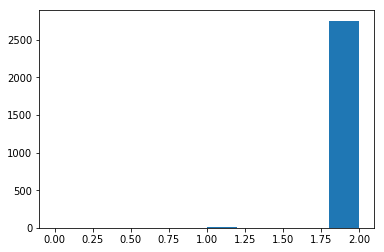

In [45]:
plt.hist(predict_y.argmax(axis=1))

In [45]:
# np.median(resample_residuals, axis=0).shape

In [46]:
# plt.plot(np.median(resample_residuals, axis=0))

In [47]:
# predict_y_median = model.predict(np.median(resample_residuals, axis=0)[np.newaxis, :, np.newaxis])

In [48]:
# predict_y_median